Коллаб
https://colab.research.google.com/drive/1EXRLhJYYfuykVX69X5N7mPVU7JMBrfw3#scrollTo=MouIuBsjOpcD

Andrey_Bondarchuk_346032105

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>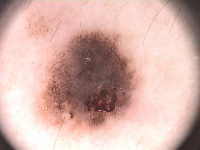</td><td>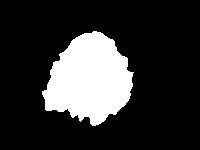</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:

from google.colab import drive
  
drive.mount('/content/gdrive/')
!unrar x /content/gdrive/My\ Drive/PH2Dataset.rar

Mounted at /content/gdrive/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/My Drive/PH2Dataset.rar

Creating    PH2Dataset                                                OK
Extracting  PH2Dataset/PH2_dataset.txt                                     0%  OK 
Extracting  PH2Dataset/PH2_dataset.xlsx                                    0%  OK 
Extracting  PH2Dataset/Readme.txt                                          0%  OK 
Creating    PH2Dataset/PH2 Dataset images                             OK
Creating    PH2Dataset/PH2 Dataset images/IMD002                      OK
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion        OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp       0

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
#root = 'PH2Dataset'
root = '/content/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

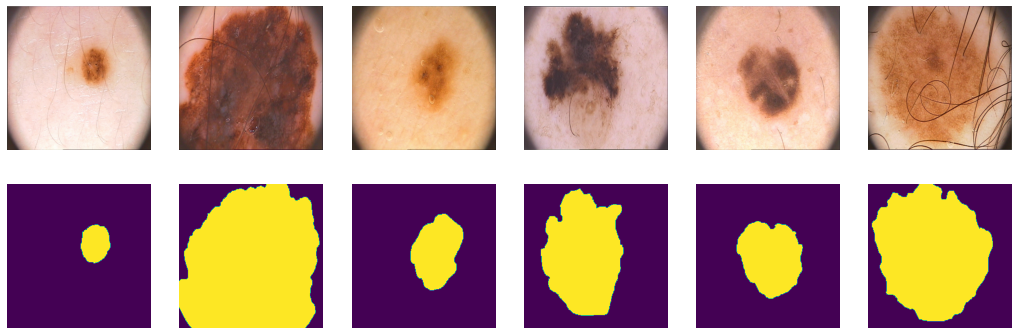

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
X.shape

(200, 256, 256, 3)

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Дополнительные импорты которые нам понадобяться в дальнейшем

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

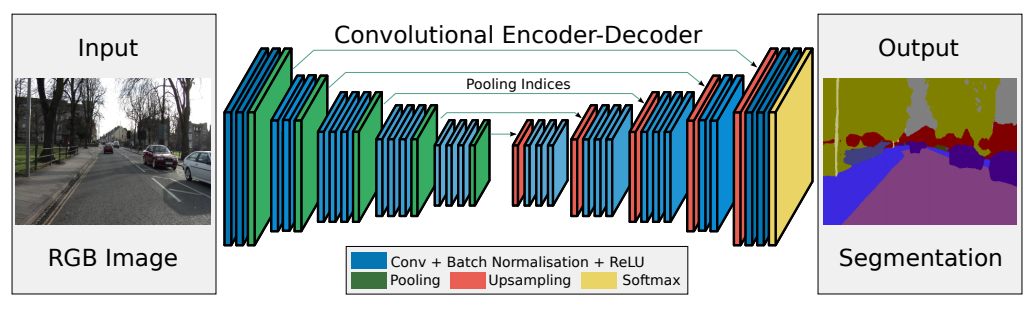


* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
from torchsummary import summary

torch.manual_seed(42)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd

из статьи   * Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf) цитируем - "The encoder network consists
of 13 convolutional layers which correspond to the first 13
convolutional layers in the VGG16 network [1] designed for object
classification."

Загружаем сетку vgg16_bn. Смотрим на неё и разбираем по слоям для SegNet. Разделитель -> MaxPool2d Всего 4 слоя, плюс так называемый bottleneck

In [ ]:
vgg16_bn = models.vgg16_bn(pretrained=False)
vgg16_bn.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
list_vgg = list(vgg16_bn.features.children())
list_vgg[0:6] # - первый слой нашей сетки... и т.д.

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True)]

### SegNet (MaxUnpool2d)

В декодере будем использовать MaxUnpool2d

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
          
        # слои vgg 0:5
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
        )
        # слой vgg 6
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)  # 256 -> 128
        
        # слои vgg 7:12
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        # слой vgg 13
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) # 128 -> 64
        
        # слои vgg 14:22
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        # слой vgg 23
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)# 64 -> 32

        # слои vgg 24:32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )
        #слой vgg 33
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) # 32 -> 16

        #bottleneck ------------------------------------------------------------------------------------------
        #слой vgg 34 - 42
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        #слой vgg 43
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True) 
        
        self.bottleneck_up = nn.MaxUnpool2d(kernel_size=2, stride=2)       
        self.bottleneck_dec_conv =  nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        #bottleneck ------------------------------------------------------------------------------------------
        
        #decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)   # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True), 
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),            
            #- 
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True), # no activation
            )

    def forward(self, x):
        # encoder -----------------------------------------

        x = self.enc_conv0(x)
        x, ind_0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind_1 = self.pool1(x)
        size1 = x.size()

        x = self.enc_conv2(x)
        x, ind_2 = self.pool2(x)
        size2 = x.size()

        x = self.enc_conv3(x)
        x, ind_3 = self.pool3(x)
        size3 = x.size()
        
        # bottleneck --------------------------------------
        x = self.bottleneck_conv(x)
        x, ind_b = self.bottleneck_pool(x)
        x = self.bottleneck_up(x, ind_b, output_size=size3)
        x = self.bottleneck_dec_conv(x)
        # bottleneck --------------------------------------
        
        # decoder -----------------------------------------
        x = self.upsample0(x, ind_3, output_size=size2)
        x = self.dec_conv0(x)

        x = self.upsample1(x, ind_2, output_size=size1)
        x = self.dec_conv1(x)

        x = self.upsample2(x, ind_1, output_size=size0)
        x = self.dec_conv2(x)

        x = self.upsample3(x, ind_0)
        x = self.dec_conv3(x)

        return x    

In [ ]:
#SegNet().to(device)
summary(SegNet().cuda(), (3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
SegNet()

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

**Вывод:** Получена необходимая архитектура сетки SegNet. В SegNet в декодере используется MaxPool2d.

### SegNet2 (Upsample bilinear)

Сделаем ещё один вариант segnet c unsample в декодере

In [ ]:
# вариант с upsample в декодере

class SegNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        # слои vgg 0:5
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
        )
        # слой vgg 6
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  # 256 -> 128
        
        # слои vgg 7:12
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        # слой vgg 13
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 128 -> 64
        
        # слои vgg 14:22
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        # слой vgg 23
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# 64 -> 32

        # слои vgg 24:32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )
        #слой vgg 33
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 32 -> 16

        #bottleneck ------------------------------------------------------------------------------------------
        #слой vgg 34 - 42
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        #слой vgg 43
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
        
        self.bottleneck_up = nn.Upsample(16, mode='bilinear')       
        self.bottleneck_dec_conv =  nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        #bottleneck ------------------------------------------------------------------------------------------
        
        #decoder (upsampling)
        self.upsample0 =  nn.Upsample(32, mode='bilinear')  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True), 
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        
        self.upsample1 = nn.Upsample(64,mode='bilinear')  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        
        self.upsample2 = nn.Upsample(64, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )

        self.upsample3 = nn.Upsample(256, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),            
            #- 
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True), # no activation
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x)) 
        e1 = self.pool1(self.enc_conv1(e0)) 
        e2 = self.pool2(self.enc_conv2(e1)) 
        e3 = self.pool3(self.enc_conv3(e2)) 

        # bottleneck 
        b = self.bottleneck_pool(self.bottleneck_conv(e3))
        b = self.bottleneck_dec_conv(self.bottleneck_up(b))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        
        return d3 
    

In [ ]:
summary(SegNet2().cuda(), (3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7         [25, 64, 128, 128]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14          [25, 128,

**Вывод:** Подготовлена сетка SegNet2 c Upsample и режимом mode='bilinear' в декодере.

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds    
    return thresholded  #    
    #return iou 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Из статьи https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits смотрим формулу:

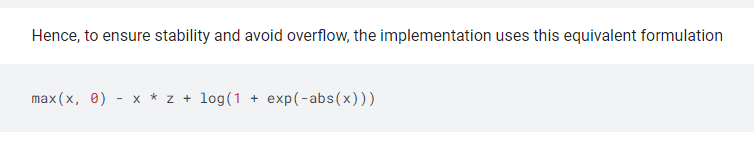

max(x,0) заменим на relu и реализуем функцию расчета Loss.

In [ ]:
def bce_loss(inputs, targets):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    
    inputs = inputs.view(-1).type(torch.float32)
    targets = targets.view(-1).type(torch.float32)
    #loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
    # приближенное вычисление 
    loss = F.relu(inputs) - targets * inputs + torch.log(1. + torch.exp(-abs(inputs)))
    return torch.mean(loss)

Сделаем класс BCE_Loss.

In [ ]:
class BCE_Loss(nn.Module):
    def __init__(self):
        super(BCE_Loss, self).__init__()

    def forward(self, inputs, targets):
        inputs = inputs.view(-1).type(torch.float32)
        targets = targets.view(-1).type(torch.float32)
        #loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
        # приближенное вычисление 
        loss = F.relu(inputs) - targets * inputs + torch.log(1. + torch.exp(-abs(inputs)))
        return torch.mean(loss)

Посмотрим, как считается наш приближенный loss и сравним его значение с оригинальным nn.BCELoss(). Пример возьмем из документации по torch.

In [ ]:
BCE_WithLogitsLoss_torch =nn.BCEWithLogitsLoss()

inputs = torch.randn(1000, requires_grad=True)
Sigmoid = nn.Sigmoid()
inputs = Sigmoid(inputs)
target = torch.empty(1000).random_(2)

output = BCE_WithLogitsLoss_torch(inputs, target)
print(output)

output = bce_loss(inputs, target)
print(output)

my_bce_loss = BCE_Loss()
output = my_bce_loss(inputs, target)
print(output)


tensor(0.7173, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7173, grad_fn=<MeanBackward0>)
tensor(0.7173, grad_fn=<MeanBackward0>)


**Вывод:** Приближенное вычисление отлично согласуется с nn.BCEWithLogitsLoss().


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def _train(model, opt, loss_fn, epochs, data_tr, data_val):

    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        #print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:           
            # data to device
            X_batch = X_batch.to(device)
            #Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch).cpu()
            # forward-pass
            loss =  loss_fn(Y_pred, Y_batch) #(inputs, targets) 
            # backward-pass   
            loss.backward()
            # update weights
            opt.step() 

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        #print('loss: %f' % avg_loss)

        # show intermediate results
        with torch.no_grad():
          model.eval()  # testing mode
          inputs = X_val.to(device)
          Y_hat = model(inputs).cpu() # detach and put into cpu
          val_loss = loss_fn(Y_hat, Y_val.cpu() ) #(inputs, targets) 
   
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
 

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    with torch.no_grad():
      model.eval()  # testing mode
      #Y_pred = [ X_batch for X_batch, _ in data] ???
      Y_pred = [ torch.round(F.sigmoid(model(X_batch.to(device)))) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    with torch.no_grad():
      model.eval()  # testing mode
      scores = 0
      for X_batch, Y_label in data:
          X_batch = X_batch.to(device)
          Y_label = Y_label.to(device)  
          Y_pred = torch.round(torch.sigmoid(model(X_batch)))          
          scores += metric(Y_pred, Y_label).mean().item()
    return scores/len(data)

### Новая функция train()

Доработаем функцию обучения train для визуальной интерпритации процесса обучения.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, visualize=True):
    #-----------------------------------------------------------------
    history_loss = []
    history_score = []
    #-----------------------------------------------------------------
  
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        #print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:           
            # data to device
            X_batch = X_batch.to(device)
            #Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch).cpu()
            # forward-pass
            loss =  loss_fn(Y_pred, Y_batch) #(inputs, targets) 
            # backward-pass   
            loss.backward()
            # update weights
            opt.step() 

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        train_time = toc - tic
        #print('loss: %f' % avg_loss)

        # show intermediate results
        with torch.no_grad():
          model.eval()  # testing mode
          inputs = X_val.to(device)
          Y_hat = model(inputs).cpu() # detach and put into cpu
          val_loss = loss_fn(Y_hat, Y_val.cpu() ) #(inputs, targets) 
          #-----------------------------------------------------------
          history_loss.append((avg_loss, val_loss))

          train_scores = score_model(model, iou_pytorch, data_tr)
          val_scores = score_model(model, iou_pytorch, data_val)
          history_score.append((train_scores, val_scores))
          #-----------------------------------------------------------

        # Visualize tools
        if visualize:
          clear_output(wait=True)
          for k in range(6):
              plt.subplot(2, 6, k+1)
              plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
              plt.title('Real')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(Y_hat[k, 0], cmap='gray')
              plt.title('Output')
              plt.axis('off')
          plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
          plt.show()

    return history_loss, history_score, train_time

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### SegNet (MaxUnpool2d)

In [ ]:
model_SegNet = SegNet().to(device)

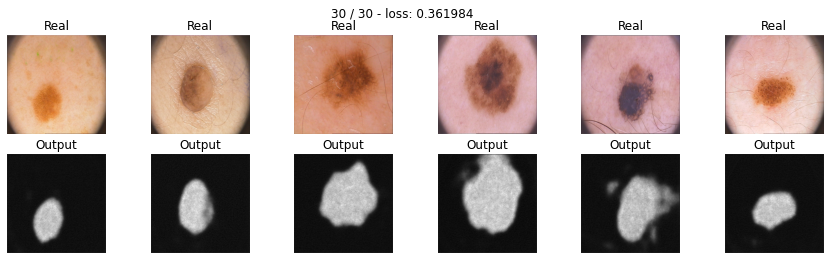

CPU times: user 2min 24s, sys: 12.4 s, total: 2min 37s
Wall time: 2min 31s


In [ ]:
%%time
max_epochs = 30 
opt = optim.Adam(model_SegNet.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_SegNet, opt, BCE_Loss(), max_epochs, data_tr, data_val) 

Ответьте себе на вопрос: не переобучается ли моя модель?

Построим график изменения loss и метрики IoU на тренировочгой и валидационной части датасета.

In [ ]:
def plot_history(history_loss, history_score, title=""):

  train_loss, val_loss = zip(*history_loss)
  train_scores, val_scores = zip(*history_score)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

  ax1.plot(train_loss, label="train_loss")
  ax1.plot(val_loss, label="val_loss")
  ax1.grid(axis='y')
  ax1.legend(loc='best')
  ax1.set_xlabel("epochs")
  ax1.set_ylabel("loss")
  ax1.set_title("Train and vall loss "+title)
  #plt.setp(ax1.get_xticklabels(), rotation=45);

  ax2.plot(train_scores, label="train_IoU")
  ax2.plot(val_scores, label="val_IoU")
  ax2.grid(axis='y')
  ax2.legend(loc='best')
  ax2.set_xlabel("epochs")
  ax2.set_ylabel("loss")
  ax2.set_title("Train and vall IoU "+title)
  #plt.setp(ax2.get_xticklabels(), rotation=45);  

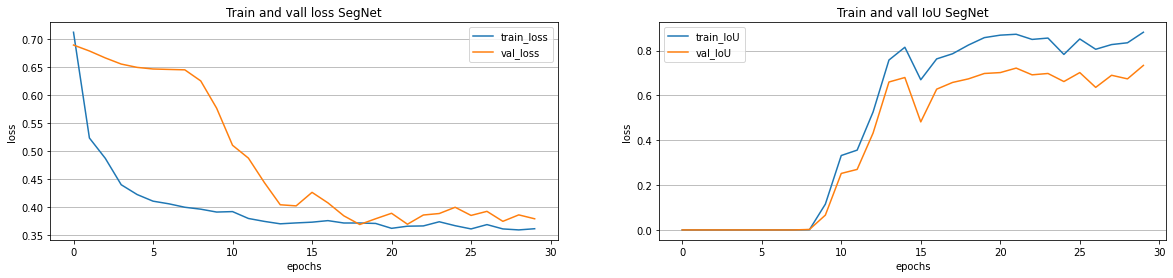

In [ ]:
plot_history(history_loss, history_score, title="SegNet")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.73400


**Вывод** Явных признаков переобучения модели - нет (отсутствует рост loss на валидационной части сэта). По метрике IoU виден устойчивый рост с каждой эпохой и получен приемлемый результат > 0.5

In [ ]:
# функция очистки кэш
def del_model(model):
  try:
    del model
  except:
    pass
  with torch.no_grad():
      torch.cuda.empty_cache()

In [ ]:
del_model(model_SegNet)

### SegNet (Upsample bilinear)

In [ ]:
model_Segnet2 = SegNet2().to(device)

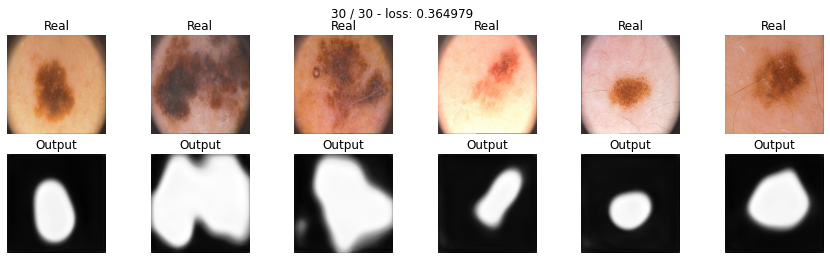

CPU times: user 2min 23s, sys: 10.7 s, total: 2min 34s
Wall time: 2min 28s


In [ ]:
%%time
max_epochs = 30 
opt = optim.Adam(model_Segnet2.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_Segnet2, opt, BCE_Loss(), max_epochs, data_tr, data_val) #my_class_bce_loss()

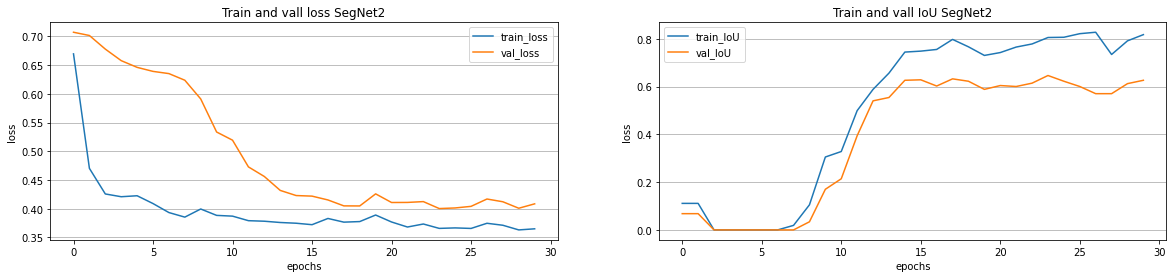

In [ ]:
plot_history(history_loss, history_score, title="SegNet2")

In [ ]:
iou = score_model(model_Segnet2, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Метрика iou =  0.62600


**Вывод**: Признаков переобучения на данной архитектуре (декодер с upsample) тоже нет. По метрике IoU получен результат > 0.5

In [ ]:
del_model(model_Segnet2)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


### Dice loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(inputs, targets):
    smooth = 1.
    inputs = inputs.view(-1).type(torch.float32)
    inputs = torch.sigmoid(inputs)
    targets = targets.view(-1).type(torch.float32)   
    loss = 1. -(1./(256.*256.)) * torch.sum((2.*inputs*targets)/(inputs + targets + smooth))   
    return loss

In [ ]:
inputs = torch.randn(1000, requires_grad=True)
targets = torch.empty(1000).random_(2)
loss = dice_loss(inputs, targets)
loss

tensor(0.9971, grad_fn=<RsubBackward1>)

Проводим тестирование:

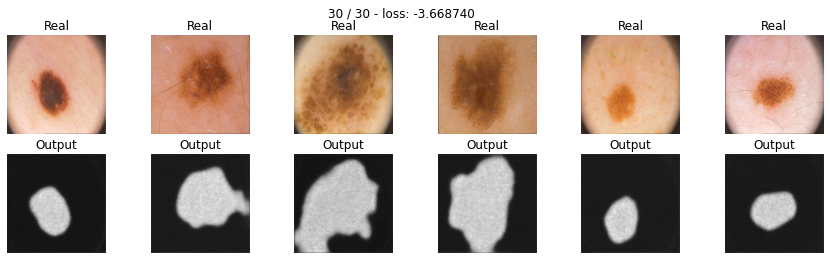

In [ ]:
model_SegNet = SegNet().to(device)

max_epochs = 30
optimaizer = optim.Adam(model_SegNet.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_SegNet, optimaizer, dice_loss, max_epochs, data_tr, data_val)

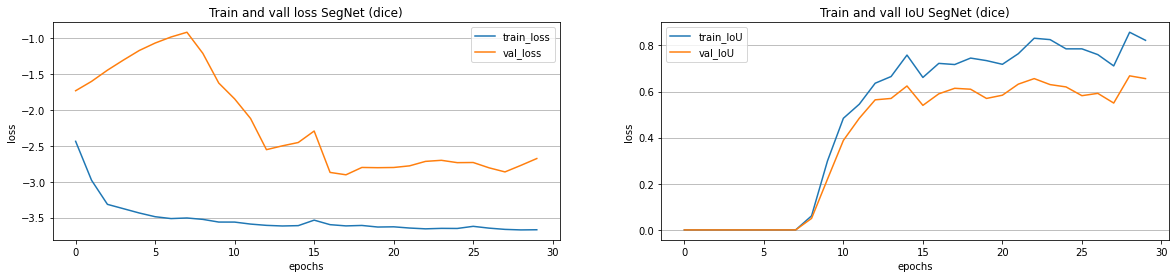

In [ ]:
plot_history(history_loss, history_score, title="SegNet (dice)")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.65600


In [ ]:
del_model(model_SegNet)

**Вывод**: Модель учиться, не переобучается и даже показывает приемлимую метрику iou > 0.5

### Еще одна реализация dice loss

$$\mathcal L_D(X,Y) = 1- \frac {\sum_i 2X_iY_i} {\sum_i X_i + \sum_i Y_i}.$$

In [ ]:
class Dice_Loss(nn.Module):
    def __init__(self):
        super(Dice_Loss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-8):       
        inputs = torch.sigmoid(inputs)       
        inputs = inputs.view(-1).type(torch.float32)
        targets = targets.view(-1).type(torch.float32)        
        intersection = torch.sum(inputs * targets)                            
        dice = (2.*intersection + smooth)/(torch.sum(inputs) + torch.sum(targets) + smooth)         
        return 1 - dice

In [ ]:
model_SegNet = SegNet().to(device)

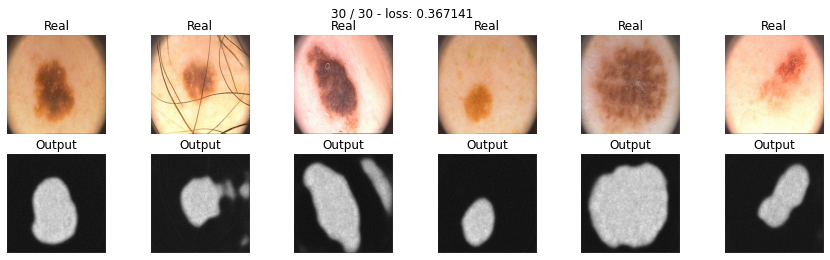

In [ ]:
max_epochs = 30
optimaizer = optim.Adam(model_SegNet.to(device)
.parameters(), lr=1e-4)
history_loss, history_score, train_time  = train(model_SegNet, optimaizer, Dice_Loss(), max_epochs, data_tr, data_val)

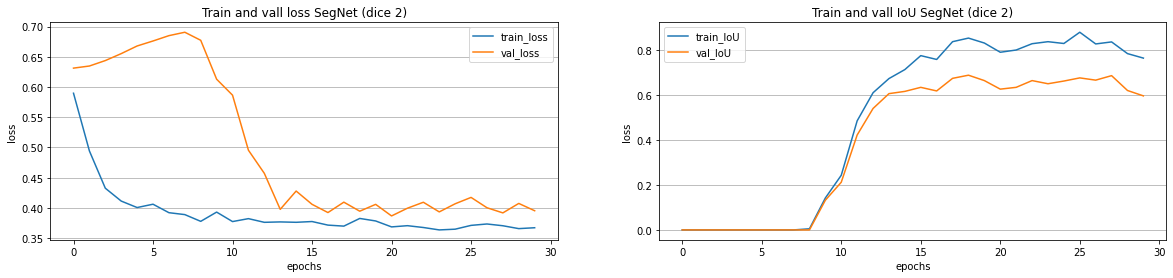

In [ ]:
plot_history(history_loss, history_score, title="SegNet (dice 2)")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.59600


Вывод: Модель учиться, не переобучается и даже показывает приемлимую метрику iou 0.5

In [ ]:
del_model(model_SegNet)

### Focal loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


Согласно статье https://arxiv.org/pdf/1708.02002.pdf focal loss можно представить в виде

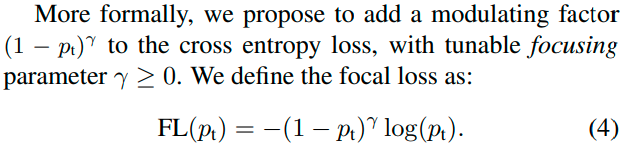

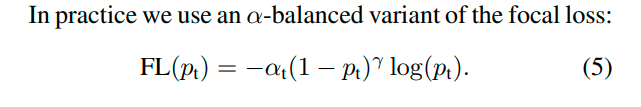

При γ = 0 фокал лосс должен превратиться в бинарную кросс энтропию. То есть фокалл лосс можно представить как коэффициент умноженный на BCE. Реализуем формулу лосса на практике:

In [ ]:
def focal_loss(inputs, targets, eps = 1e-8, gamma = 2, alpha=0.5):
    #y_pred =  # hint: torch.clamp
    inputs = inputs.view(-1).type(torch.float32)
    targets = targets.view(-1).type(torch.float32)        
    BCE = bce_loss(inputs, targets)
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1-BCE_EXP)**gamma * BCE    
    return focal_loss

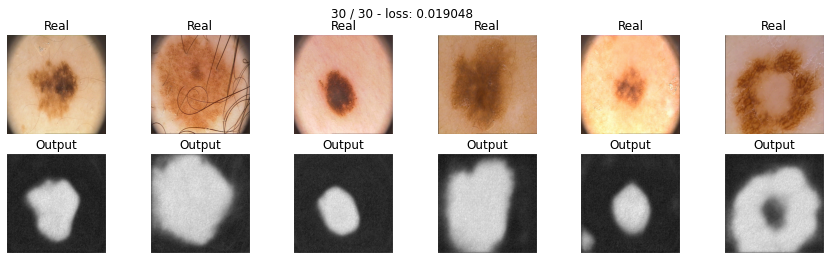

In [ ]:
model_SegNet = SegNet().to(device)
max_epochs = 30
optimaizer = optim.Adam(model_SegNet.parameters(), lr=1e-4)
history_loss, history_score, train_time   = train(model_SegNet, optimaizer, focal_loss, max_epochs, data_tr, data_val)

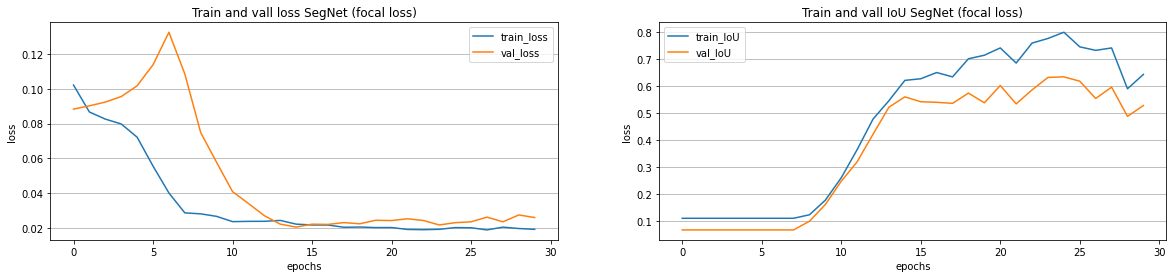

In [ ]:
plot_history(history_loss, history_score, title="SegNet (focal loss)")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.52800


In [ ]:
del_model(model_SegNet)

**Вывод** Модель с focal loss обучена. Видны признаки переобучения модели.     Метрика iou >0.5.

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### Тверский лосс

https://arxiv.org/pdf/1706.05721.pdf

The output layer in the network consists of c planes, one per class (c = 2 in
lesion detection). We applied softmax along each voxel to form the loss. Let P
and G be the set of predicted and ground truth binary labels, respectively. The
Dice similarity coefficient D between two binary volumes is defined as:
$$D(P, G) = 2|P G|/(|P| + |G|)$$
(1)
If this is used in a loss layer in training [13], it weighs FPs and FNs (precision
and recall) equally. In order to weigh FNs more than FPs in training our network
for highly imbalanced data, where detecting small lesions is crucial, we propose
a loss layer based on the Tversky index [19]. The Tiversky index is defined as:
$$S(P, G; α, β) = |P G| / (|P G| + α|P / G| + β|G / P|)$$

In [ ]:
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        inputs = torch.sigmoid(inputs)       
        inputs = inputs.view(-1).type(torch.float32)
        targets = targets.view(-1).type(torch.float32)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

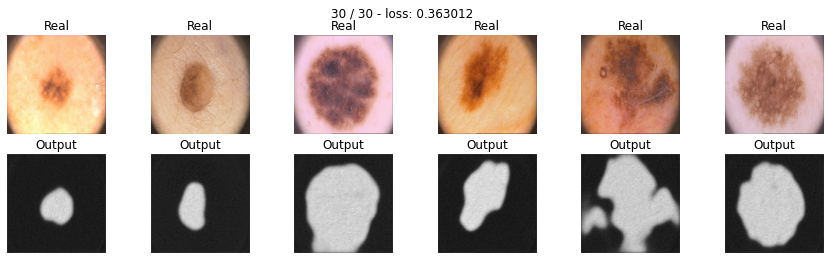

In [ ]:
model_SegNet = SegNet().to(device)
max_epochs = 30
optimaizer = optim.Adam(model_SegNet.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_SegNet, optimaizer, TverskyLoss(), max_epochs, data_tr, data_val)

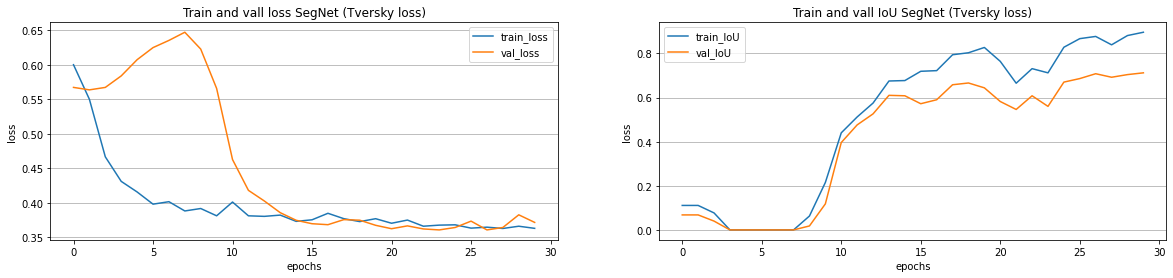

In [ ]:
plot_history(history_loss, history_score, title="SegNet (Tversky loss)")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.71200


In [ ]:
del_model(model_SegNet)

**Вывод** Модель с tversky loss успешно обучена. Метрика iou >0.5

### Jaccard/Intersection over Union (IoU) Loss

Попробуем сделать функцию лосса наиболее соответствующую нашей задаче с целевой метрикой IoU.

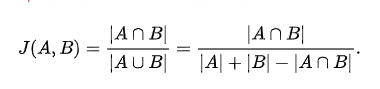

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1).type(torch.float32)
        targets = targets.view(-1).type(torch.float32)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

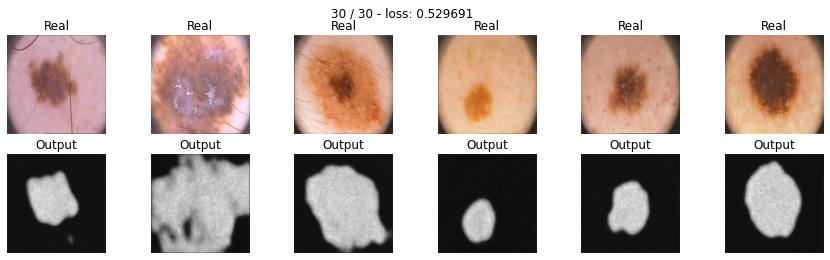

In [ ]:
model_SegNet = SegNet().to(device)
max_epochs = 30
optimaizer = optim.Adam(model_SegNet.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_SegNet, optimaizer, IoULoss(), max_epochs, data_tr, data_val)

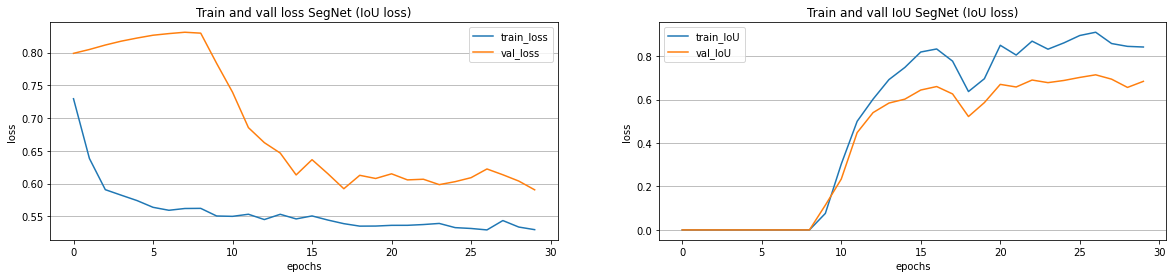

In [ ]:
plot_history(history_loss, history_score, title="SegNet (IoU loss)")

In [ ]:
iou = score_model(model_SegNet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.68400


In [ ]:
del_model(model_SegNet)

Вывод Модель с IoU loss успешно обучена. Метрика iou >0.5

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

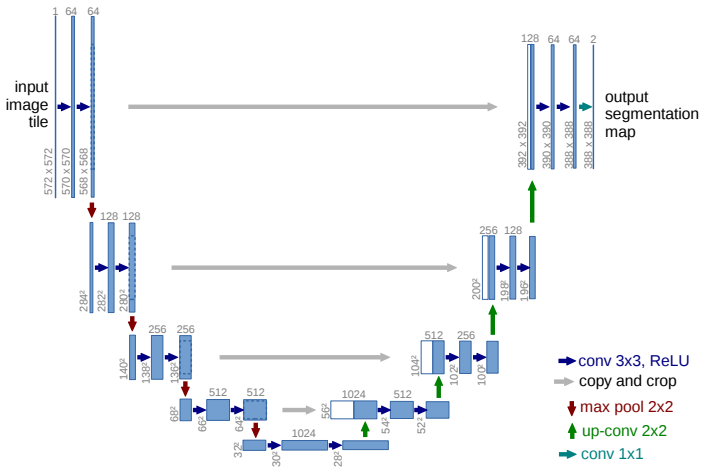

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 32 -> 16

        #bottleneck ------------------------------------------------------------------------------------------
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
          
            )
        #bottleneck ------------------------------------------------------------------------------------------
        
        #decoder (upsampling)
        self.upsample0 =  nn.UpsamplingNearest2d(32)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True), 
            #-
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        
        self.upsample1 = nn.UpsamplingNearest2d(64)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        
        self.upsample2 = nn.UpsamplingNearest2d(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )

        self.upsample3 = nn.UpsamplingNearest2d(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),            
            #- 
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True), # no activation
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) 
        e0_pool = self.pool0(e0) 
        
        e1 = self.enc_conv1(e0_pool) 
        e1_pool = self.pool1(e1) 
        
        e2 = self.enc_conv2(e1_pool) 
        e2_pool = self.pool2(e2) 
        
        e3 = self.enc_conv3(e2_pool) 
        e3_pool = self.pool3(e3) 

        # bottleneck 
        b = self.bottleneck_conv(e3_pool)
        #b = self.bottleneck_pool(b)
          
        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], axis=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], axis=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], axis=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], axis=1)
        d3 = self.dec_conv3(d3)
      
        return d3 
      

In [ ]:
summary(UNet().cuda(), (3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
         MaxPool2d-7         [25, 64, 128, 128]               0
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
        MaxPool2d-14          [25, 128,

Обучим модель

In [ ]:
model_Unet = UNet().to(device)

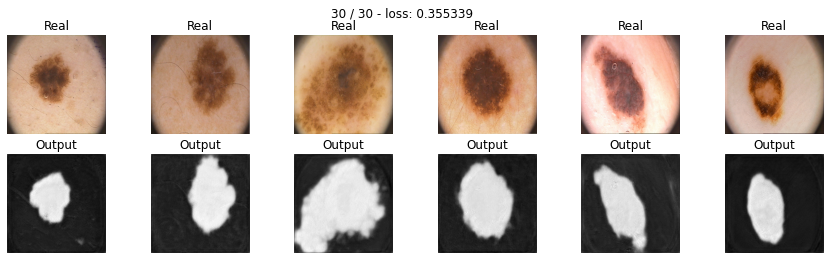

In [ ]:
max_epochs = 30
optimaizer = optim.Adam(model_Unet.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_Unet, optimaizer, bce_loss, max_epochs, data_tr, data_val)

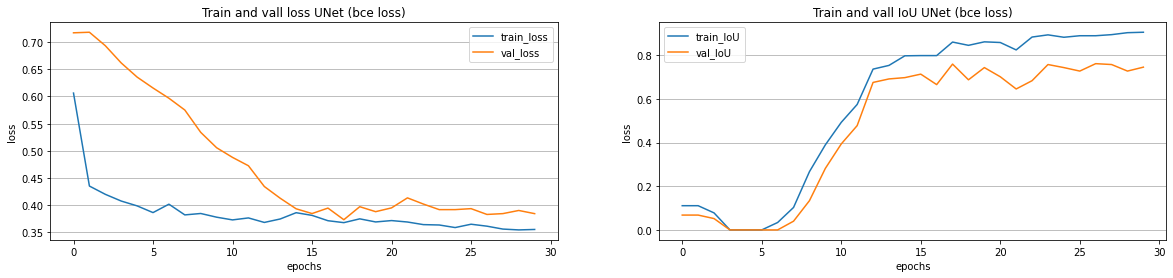

In [ ]:
plot_history(history_loss, history_score, title="UNet (bce loss)")

In [ ]:
iou = score_model(model_Unet, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.74600


In [ ]:
del_model(model_Unet)

**Вывод:** Модель U-net показала лучшие результаты по метрике iou.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
        )
        #self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)  # 256 -> 128
        self.pool0 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        #self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 128 -> 64
        self.pool1 =  nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        #self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# 64 -> 32
        self.pool2 =  nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )
        #self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) # 32 -> 16
        self.pool3 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)) # 32 -> 16

        #bottleneck ------------------------------------------------------------------------------------------
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        #bottleneck ------------------------------------------------------------------------------------------
        
        #decoder (upsampling)
        self.upsample0 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True), 
            #-
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            )
        
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            )
        
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            #-
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)            
            )

        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),            
            #- 
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.ReLU(inplace=True), # no activation
            )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) 
        e0_pool = self.pool0(e0) 
        
        e1 = self.enc_conv1(e0_pool) 
        e1_pool = self.pool1(e1) 
        
        e2 = self.enc_conv2(e1_pool) 
        e2_pool = self.pool2(e2) 
        
        e3 = self.enc_conv3(e2_pool) 
        e3_pool = self.pool3(e3) 

        # bottleneck 
        b = self.bottleneck_conv(e3_pool)
        #b = self.bottleneck_pool(b)
          
        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], axis=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], axis=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], axis=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], axis=1)
        d3 = self.dec_conv3(d3)
      
        return d3 
      

In [ ]:
summary(UNet2().cuda(), (3, 256, 256), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [25, 64, 256, 256]           1,792
       BatchNorm2d-2         [25, 64, 256, 256]             128
              ReLU-3         [25, 64, 256, 256]               0
            Conv2d-4         [25, 64, 256, 256]          36,928
       BatchNorm2d-5         [25, 64, 256, 256]             128
              ReLU-6         [25, 64, 256, 256]               0
            Conv2d-7         [25, 64, 128, 128]          36,928
            Conv2d-8        [25, 128, 128, 128]          73,856
       BatchNorm2d-9        [25, 128, 128, 128]             256
             ReLU-10        [25, 128, 128, 128]               0
           Conv2d-11        [25, 128, 128, 128]         147,584
      BatchNorm2d-12        [25, 128, 128, 128]             256
             ReLU-13        [25, 128, 128, 128]               0
           Conv2d-14          [25, 128,

In [ ]:
model_Unet2 = UNet2().to(device)

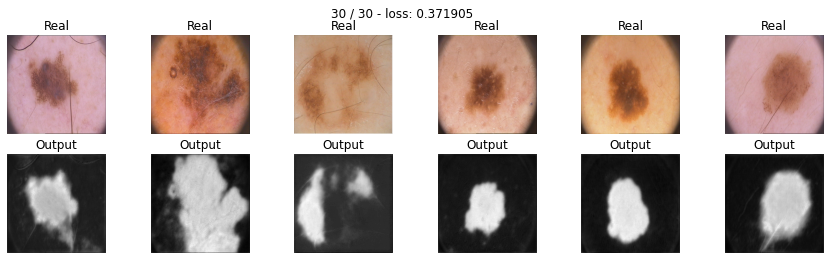

In [ ]:
max_epochs = 30
optimaizer = optim.Adam(model_Unet2.parameters(), lr=1e-4)
history_loss, history_score, train_time = train(model_Unet2, optimaizer, bce_loss, max_epochs, data_tr, data_val)

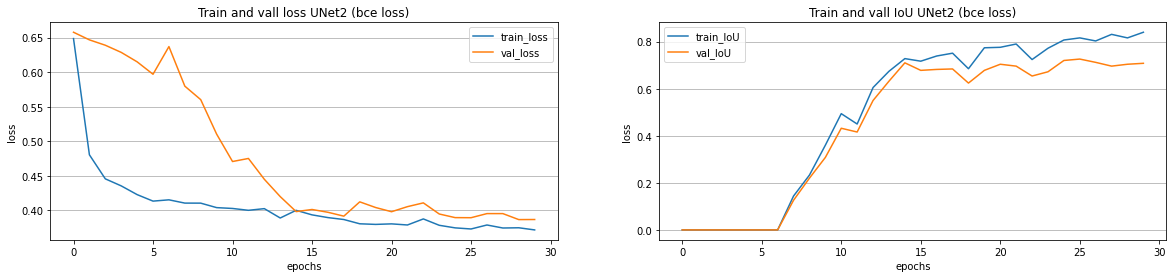

In [ ]:
plot_history(history_loss, history_score, title="UNet2 (bce loss)")

In [ ]:
iou = score_model(model_Unet2, iou_pytorch, data_val)
print("Метрика iou = {:8.5f}".format(iou))

Метрика iou =  0.70800


In [ ]:
del_model(model_Unet2)

**Вывод** Для окончательного вывода необходимо провести сравнительный анализ трех моделей **Unet, Unet2 и SegNet** Для этого обучим модели с различными loss, рассчитаем целевую метрику на валидационной части датасета и соберем данные в сводную таблицу.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Дополнительное исследование

Возьмем наши модели и обучим их с различными функциями потерь. Результат будем собирать в датафрэймы и промежуточные данные сбрасывать на диск. (на случай cuda out of memory)

### SegNet с различными loss

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
# список используемых loss
loss_dict = {'bce':bce_loss,'dice':dice_loss, 'focal':focal_loss, 'Tversky':TverskyLoss(), 'IoU':IoULoss()}

In [ ]:
%%time

max_epochs = 30

frame=[]
for key in tqdm(loss_dict.keys()): 
  loss_fn = loss_dict[key]
  # model
  model = SegNet().to(device)

  optimaizer = optim.Adam(model.parameters(), lr=1e-4)
  history_loss, history_score, train_time = train(model, optimaizer, loss_fn, max_epochs, data_tr, data_val, False)

  iou_val = score_model(model, iou_pytorch, data_val)
  iou_train = score_model(model, iou_pytorch, data_tr)

  frame.append(pd.DataFrame({ 
                         'model': 'Segnet',
                         'loss' : key ,
                         'history_loss' : history_loss,
                         'history_score' : history_score,
                         'iou_train': iou_train,
                         'iou_val': iou_val,
                         'time':train_time}
                          )    
  )

  del_model(model)

# результаты сбросим в файл на диск 
df = pd.concat(frame)
df.to_pickle("segnet_loss.pkl")

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 10min 18s, sys: 1min 4s, total: 11min 23s
Wall time: 10min 56s


### Unet с различными loss

In [ ]:
%%time

max_epochs = 30
frame=[]
for key in tqdm(loss_dict.keys()): 
  loss_fn = loss_dict[key]
  # model
  model = UNet().to(device)

  optimaizer = optim.Adam(model.parameters(), lr=1e-4)
  history_loss, history_score, train_time = train(model, optimaizer, loss_fn, max_epochs, data_tr, data_val, False)

  iou_val = score_model(model, iou_pytorch, data_val)
  iou_train = score_model(model, iou_pytorch, data_tr)

  frame.append(pd.DataFrame({ 
                         'model': 'UNet',
                         'loss' : key ,
                         'history_loss' : history_loss,
                         'history_score' : history_score,
                         'iou_train': iou_train,
                         'iou_val': iou_val,
                         'time':train_time}
                          )    
  )
  
  del_model(model)

# результаты сбросим в файл на диск 
df = pd.concat(frame)
df.to_pickle("unet_loss.pkl")

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 11min 38s, sys: 4.79 s, total: 11min 43s
Wall time: 11min 18s


In [ ]:
#del_model(model)
#pd.read_pickle("./dummy.pkl")

### Unet2 с различными loss

In [ ]:
%%time

max_epochs = 30
frame=[]
for key in tqdm(loss_dict.keys()): 
  loss_fn = loss_dict[key]
  # model
  model = UNet2().to(device)

  optimaizer = optim.Adam(model.parameters(), lr=1e-4)
  history_loss, history_score, train_time = train(model, optimaizer, loss_fn, max_epochs, data_tr, data_val, False)

  iou_val = score_model(model, iou_pytorch, data_val)
  iou_train = score_model(model, iou_pytorch, data_tr)

  frame.append(pd.DataFrame({ 
                         'model': 'UNet2',
                         'loss' : key ,
                         'history_loss' : history_loss,
                         'history_score' : history_score,
                         'iou_train': iou_train,
                         'iou_val': iou_val,
                         'time':train_time}
                          )    
  )
   
  del_model(model)

# результаты сбросим в файл на диск 
df = pd.concat(frame)
df.to_pickle("unet2_loss.pkl")

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 14min 40s, sys: 4.08 s, total: 14min 44s
Wall time: 14min 18s


### Соберем итоговую таблицу с данными

In [ ]:
df_unet2 = pd.read_pickle("unet2_loss.pkl")
df_unet = pd.read_pickle("unet_loss.pkl")
df_segnet = pd.read_pickle("segnet_loss.pkl")

df_segnet = df_segnet.reset_index()
df_segnet = df_segnet.rename(columns={df_segnet.columns[0]: 'epoch'})
df_unet = df_unet.reset_index()
df_unet = df_unet.rename(columns={df_unet.columns[0]: 'epoch'})
df_unet2 = df_unet2.reset_index()
df_unet2 = df_unet2.rename(columns={df_unet2.columns[0]: 'epoch'})

In [ ]:
df_all = pd.concat([df_segnet,df_unet,df_unet2])

In [ ]:
report = df_all[df_all.epoch==29][['model','loss','iou_train','iou_val','time']].reset_index().sort_values(by='iou_val')
report = report.drop('index',axis=1)

In [ ]:
report.sample(5, random_state=42)

,model,loss,iou_train,iou_val,time
10,UNet2,bce,0.835,0.736,3.035538
7,UNet,focal,0.891,0.760,2.446488
3,Segnet,Tversky,0.740,0.588,2.487188
14,UNet2,IoU,0.796,0.774,2.982727
12,UNet2,focal,0.784,0.692,3.035592


### Визуальный анализ динамики обучения различных архитектур сетей при различных функциях лосс на валидационной части датасета.

Построим графики отражающие процесс обучения по эпохам на валидационной части датасета.

In [ ]:
import matplotlib.pyplot as plt

def plot_set(df, title=""):
    train_IoU, val_IoU = zip(*(df[df.loss=='IoU']['history_score'].tolist()))
    train_bce, val_bce = zip(*(df[df.loss=='bce']['history_score'].tolist()))
    train_focal, val_focal = zip(*(df[df.loss=='focal']['history_score'].tolist()))
    train_dice, val_dice = zip(*(df[df.loss=='dice']['history_score'].tolist()))
    train_Tversky, val_Tversky = zip(*(df[df.loss=='Tversky']['history_score'].tolist()))


    train_loss_IoU, val_loss_IoU = zip(*(df[df_unet.loss=='IoU']['history_loss'].tolist()))
    train_loss_bce, val_loss_bce = zip(*(df[df_unet.loss=='bce']['history_loss'].tolist()))
    train_loss_focal, val_loss_focal = zip(*(df[df.loss=='focal']['history_loss'].tolist()))
    train_loss_dice, val_loss_dice = zip(*(df[df.loss=='dice']['history_loss'].tolist()))
    train_loss_dice, val_loss_dice = zip(*(df[df.loss=='dice']['history_loss'].tolist()))
    train_loss_Tversky, val_loss_Tversky = zip(*(df[df.loss=='Tversky']['history_loss'].tolist()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(val_loss_IoU, label="IoU")
    ax1.plot(val_loss_bce, label="bce")
    ax1.plot(val_loss_focal, label="focal")
    #ax1.plot(val_loss_dice, label="dice")
    ax1.plot(val_loss_Tversky, label="Tversky")
    ax1.grid(axis='y')
    ax1.legend(loc='best')
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    ax1.set_title("loss "+title)

    ax2.plot(val_IoU, label="IoU")
    ax2.plot(val_bce, label="bce")
    ax2.plot(val_focal, label="focal")
    #ax2.plot(val_dice, label="dice")
    ax2.plot(val_Tversky, label="Tversky")
    ax2.grid(axis='y')
    ax2.legend(loc='best')
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("loss")
    ax2.set_title(" метрика IoU "+title)


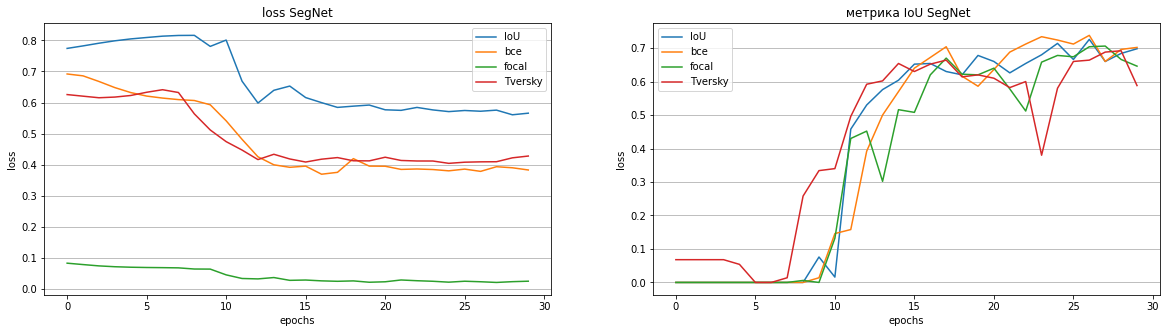

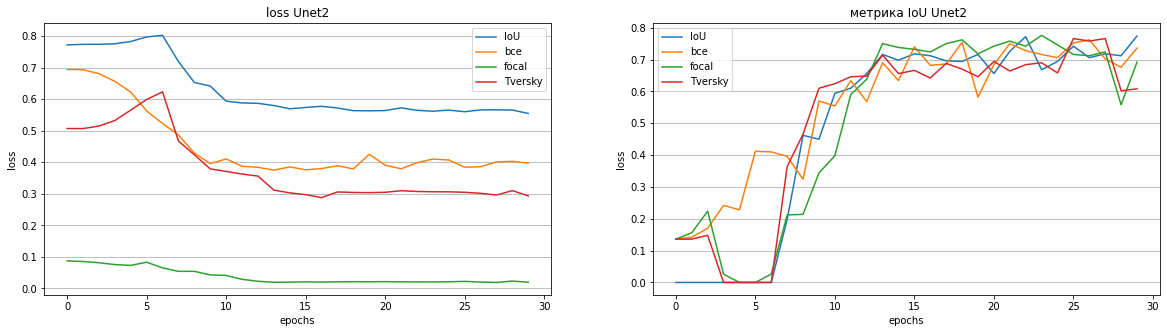

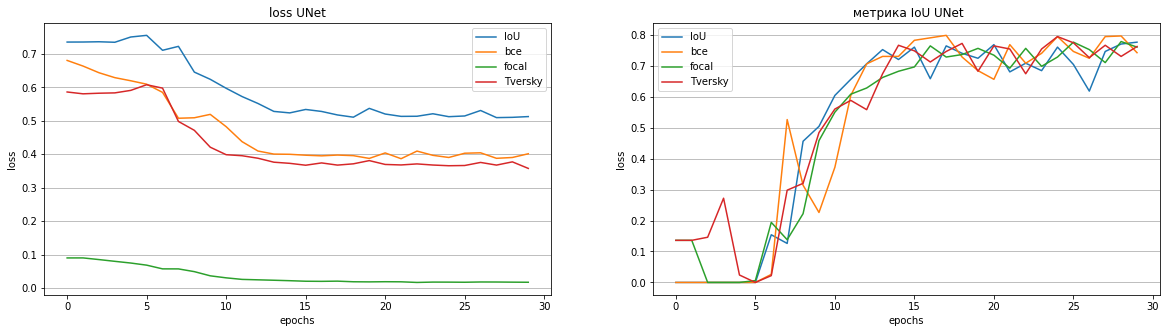

In [ ]:
plot_set(df_segnet, "SegNet")
plot_set(df_unet2, "Unet2")
plot_set(df_unet, "UNet")

**Вывод** Можно сделать вывод, что архитектура UNet в конце процесса обучения (эпохи 15 - 30) показывает наиболее стабильное поведение на различных функциях потерь loss. На некоторых графиках с loss начинает быть заметным небольшое переобучение. Например для Unet2 лосс bce начинает незначительно расти.

### Таблица значений метрики IoU c различными функциями loss для SegNet

In [ ]:
rep_segnet = report[report.model == 'Segnet']
rep_segnet

,model,loss,iou_train,iou_val,time
3,Segnet,Tversky,0.740,0.588,2.487188
2,Segnet,focal,0.835,0.646,2.512578
1,Segnet,dice,0.785,0.656,2.477445
4,Segnet,IoU,0.850,0.698,2.451394
0,Segnet,bce,0.877,0.702,2.517628


Видно, что наилучшие результаты показал IoU и bce.

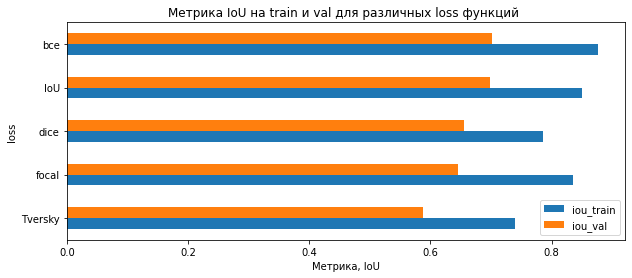

In [ ]:
ax = rep_segnet[['loss','iou_train','iou_val']].set_index('loss').sort_values(by='iou_val').plot(kind='barh', figsize=(10,4))
ax.set_title("Метрика IoU на train и val для различных loss функций ")
ax.set_xlabel("Метрика, IoU");

**Вывод**  Для SegNet наилучшие результаты по значению целевой метрики IoU  получены для функций потерь bce и IoU.

### Таблица значений метрики IoU c различными функциями loss для UNet.

In [ ]:
rep_unet = report[report.model == 'UNet']
rep_unet

,model,loss,iou_train,iou_val,time
6,UNet,dice,0.805,0.698,2.415805
5,UNet,bce,0.901,0.742,2.440702
7,UNet,focal,0.891,0.760,2.446488
8,UNet,Tversky,0.852,0.762,2.423663
9,UNet,IoU,0.907,0.776,2.387726


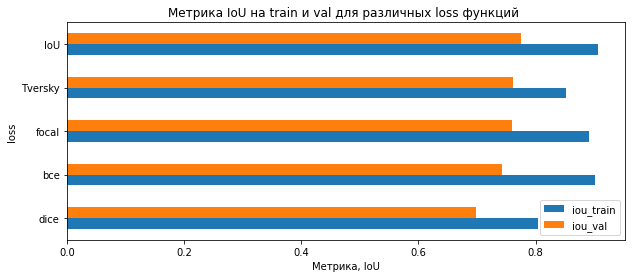

In [ ]:
ax = rep_unet[['loss','iou_train','iou_val']].set_index('loss').sort_values(by='iou_val').plot(kind='barh', figsize=(10,4))
ax.set_title("Метрика IoU на train и val для различных loss функций ")
ax.set_xlabel("Метрика, IoU");

**Вывод**  Для UNet наилучшие результаты по значению целевой метрики IoU  получены для функций потерь tversky и IoU.

### Таблица значений метрики IoU c различными функциями loss для UNet2.

In [ ]:
rep_unet2 = report[report.model == 'UNet2']
rep_unet2

,model,loss,iou_train,iou_val,time
13,UNet2,Tversky,0.676,0.608,3.003951
11,UNet2,dice,0.756,0.654,3.016387
12,UNet2,focal,0.784,0.692,3.035592
10,UNet2,bce,0.835,0.736,3.035538
14,UNet2,IoU,0.796,0.774,2.982727


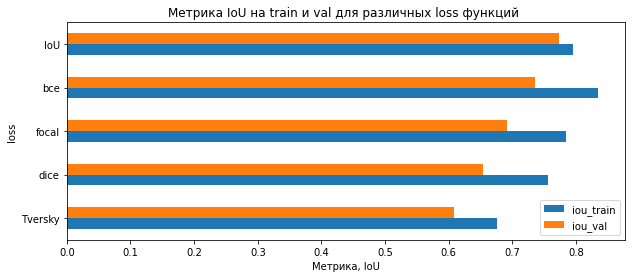

In [ ]:
ax = rep_unet2[['loss','iou_train','iou_val']].set_index('loss').sort_values(by='iou_val').plot(kind='barh', figsize=(10,4))
ax.set_title("Метрика IoU на train и val для различных loss функций ")
ax.set_xlabel("Метрика, IoU");

**Вывод**  Для UNet2 наилучшие результаты по значению целевой метрики IoU  получены для функций потерь bce и IoU.

### Наилучшие результаты для всех архитектур.

In [ ]:
rep = pd.concat([report[report.model == 'UNet2'].tail(1), report[report.model == 'UNet'].tail(1), report[report.model == 'Segnet'].tail(1)])
rep = rep.sort_values(by='iou_val')
rep

,model,loss,iou_train,iou_val,time
0,Segnet,bce,0.877,0.702,2.517628
14,UNet2,IoU,0.796,0.774,2.982727
9,UNet,IoU,0.907,0.776,2.387726


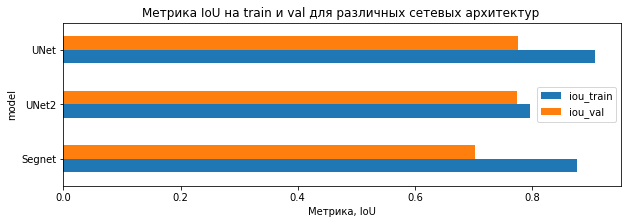

In [ ]:
ax= rep[['iou_train', 'iou_val','model']].set_index('model').sort_values(by='iou_val').plot(kind='barh', figsize=(10,3))
ax.set_xlabel("Метрика, IoU");
ax.set_title("Метрика IoU на train и val для различных сетевых архитектур ");

## Выводы

Были реализованы три типа архитектур для задачи сегментации. Это SegNet c MaxUnpool2d в декодере, UNet c MaxPool2d в энкодере и UpsamplingNearest2d в декодере и UNet2 с Conv2d (вместо MaxPool2d) в энкодере и ConvTranspose2d в декодере. 

Окончательные выводы по дополнительному сравнительному исследованию можно сделать следующие:


*   Наилучшей архитектурой по значениям целевой метрики является UNet
*   Наилучшие результаты по значениям целевой метрики показывает применение при обучении функций потерь IoU и bce
*   Дольше всего по времени обучается UNet2, быстрее всех SegNet.








**Поэтому, наши рекомендации - это UNet c функцией потерь IoU.**